In [2]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import json

from skbio import OrdinationResults
from biom import load_table
from matplotlib_venn import venn2
from matplotlib_venn.layout.venn2 import DefaultLayoutAlgorithm as Venn2Layout

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Define functions

In [3]:
def rename_feats(features_to_use, taxonomy_18s_nosp,
                 taxonomy_mag, metab_ids, tables):
    
    index_dict = {'metabolite': [], 
                  'mag': [], 
                  '18S': [], 
                  'gene_module': [],
                  'metabolomics': []}
    modality_map = {}

    for ind_ in features_to_use:
        if ind_ in taxonomy_18s_nosp.index:
            label_ = taxonomy_18s_nosp.loc[ind_, :].dropna()
            label_ = label_.values[-1] + ' (' + label_.index[-1] + ')'
            index_dict['18S'].append((ind_, label_))
            modality_map[label_] = 'Eukaryotes (18S)'

        elif ind_ in taxonomy_mag.index:
            label_ = taxonomy_mag.loc[ind_, :].dropna()
            label_ = label_.values[-1] + ' (' + label_.index[-1] + ')'
            index_dict['mag'].append((ind_, label_))
            modality_map[label_] = 'Bacterial Genomes (MetaG)'
            
        elif ind_ in metab_ids.index:
            label_ = metab_ids.loc[ind_, 'most specific class']
            index_dict['metabolite'].append((ind_, label_))
            modality_map[label_] = 'Metabolites'
            
        else:
            if ind_ in tables['mag'].ids('observation'):
                index_dict['mag'].append((ind_, ind_))
                modality_map[ind_] = 'Bacterial Genomes (MetaG)'
            elif ind_ in tables['18S'].ids('observation'):
                index_dict['18S'].append((ind_, ind_))
                modality_map[ind_] = 'Eukaryotes (18S)'
            elif ind_ in tables['gene_module'].ids('observation'):
                index_dict['gene_module'].append((ind_, ind_))
                modality_map[ind_] = 'Functions (MetaG)'
            elif ind_ in tables['metabolomics'].ids('observation'):
                index_dict['metabolomics'].append((ind_, ind_))
                modality_map[ind_] = 'Metabolites'

    #clean lists in index_dict
    for modality, feature in index_dict.items():
        #clean_lst = ['drop' if len(str(i_)) == 0 else i_ for i_ in feature]
        #clean_lst = ['drop' if str(i_) == 'nan' else i_ for i_ in clean_lst]
        clean_lst = [(i_[0], i_[1].replace('_',' ')) for i_ in feature]
        #drop features
        index_dict[modality] = [i_ for i_ in clean_lst if i_ != 'drop']

    return index_dict

## Load data

In [4]:
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/Original/ord.txt')
#load shared metadata
#metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [5]:
# import the rest
all_tables = {'18S':'../data/split-matched-data/18S.biom',
              'mag':'../data/split-matched-data/mag.biom',
              'gene':'../data/split-matched-data/gene.biom',
              'gene_module':'../data/split-matched-data/gene_module.biom',
              'metabolite':'../data/split-matched-data/metabolite.biom',
              'metabolomics':'../data/split-matched-data/metabolomics.biom'}

tables = {}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = load_table(tbl_path)

In [6]:
# annots for tables
taxonomy_18s = pd.read_csv('../data/annotations/18S_taxonomy.tsv', sep='\t', index_col=0)
taxonomy_18s = {k:{z.split('__')[0]:z.split('__')[-1]
               for z in x.split(';')} for k, x in zip(taxonomy_18s.index, taxonomy_18s.Taxon.values)}
taxonomy_18s = pd.DataFrame(taxonomy_18s).T
taxonomy_18s_nosp = taxonomy_18s.drop([' s'], axis=1)

taxonomy_mag = pd.read_csv('../data/annotations/MAG_taxonomy.tsv', sep='\t', index_col=0)
taxonomy_mag = {k:{z.split('__')[0]:z.split('__')[-1]
               for z in x.split(';')} for k, x in zip(taxonomy_mag.index, taxonomy_mag.Taxon.values)}
taxonomy_mag = pd.DataFrame(taxonomy_mag).T
taxonomy_mag[taxonomy_mag == ''] = np.nan

metab_ids = pd.read_excel('../data/metabolite_formulas.xlsx', index_col=0)
metab_ids.index = ['metab_' + str(x) for x in metab_ids.index]
metab_ids_class = metab_ids.dropna(subset=['most specific class'])

In [7]:
bt_tmp = tables['metabolite']
keep_metab = set(metab_ids_class.index) & set(bt_tmp.ids('observation'))
bt_tmp = bt_tmp.filter(keep_metab, axis='observation')
#df_tmp = df_tmp.loc[list(keep_metab), :]
#ord_tmp = ord_tmp.loc[list(keep_metab), :].sort_values(by=axis_use)
tables['metabolite'] = bt_tmp
#tables['metabolite'] = [bt_tmp, df_tmp, ord_tmp]

In [8]:
#retrieve feature loadings from joint-rpca
joint_features = ord_joint.features

#for 18S, need to make sure features are in the original table
not_in_ord_18S = []
in_ord_18S = []

for id in tables['18S'].ids(axis='observation'):
    if id not in joint_features.index:
        not_in_ord_18S.append(id)
    else:
        in_ord_18S.append(id)
print("Not in ordination results: %i" % len(not_in_ord_18S))
print("In ordination results: %i" % len(in_ord_18S))

#keep only common features
tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')

Not in ordination results: 42
In ordination results: 5431


## RPCA and Joint-RPCA
Top 20 and bottom 20 features

In [9]:
#load json files
with open('../results/joint-rpca/network/joint_decomposer_feats.json', 'r') as f:
    joint_feats = json.load(f)

with open('../results/joint-rpca/network/rpca_decomposer_feats.json', 'r') as f:
    rpca_feats = json.load(f)

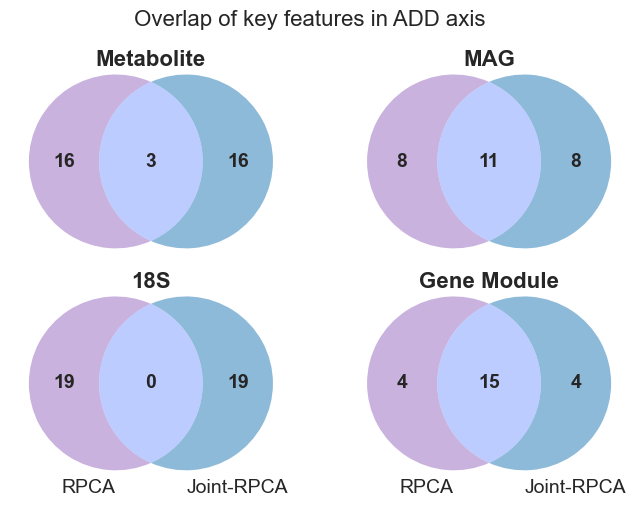

Overlapping features:
{'metabolite': {'metab_443', 'metab_150', 'metab_2750'}, 'mag': {'CMU.bins.224', 'SHSU.bins.319', 'SHSU.bins.175', 'UTK.bins.50', 'CMU_advanced.final.11', 'UTK.bins.71', 'SHSU_advanced.final.35', 'UTK_active.final.26', 'SHSU.bins.42', 'UTK.bins.19', 'CMU.bins.248'}, '18S': set(), 'gene_module': {'0DH:ubiquinone_oxidoreductase_mitochondria', 'Arginine/ornithine_transport_system', 'RNF_complex', 'D0_polymerase_II_complex_archaea', 'Putrescine_transport_system', 'Arginine/lysine/histidine/glutamine_transport_system', 'Tyrosine_biosynthesis_prephanate_to_pretyrosine_to_tyrosine', 'D-Methionine_transport_system', 'Type_I_signiture_cas_proteins', 'Adhesin_protein_transport_system', 'Na_-transporting_0DH:ubiquinone_oxidoreductase-', 'Cytochrome_o_ubiquinol_oxidase', 'Universal_Cas_proteins', 'Trehalose_transport_system', 'Taurine_transport_system'}}


In [47]:
#plot a venn diagram per omic
omic_title = {'18S': '18S', 'mag': 'MAG', 
              'gene_module': 'Gene Module', 'metabolite': 'Metabolite'}
overlap_feats_omic = {}
rpca_only_feats = {}
joint_only_feats = {}
#define direction for each omic
#e.g. num features = advanced, denom features = initial 
direction = {'metabolite': 0, 'mag': 0,
             '18S': 0, 'gene_module': 0}

#RPCA
fig, axn = plt.subplots(2, 2, figsize=(8, 7))
#reduce padding between subplots
plt.subplots_adjust(wspace=0.2, hspace=-0.3)

for ax_, omic_id in zip(axn.flatten(), joint_feats.keys()):
    
   ##check overlap between
   rpca_dir = direction[omic_id]
   rpca_feats_all = rpca_feats[omic_id][rpca_dir]
   joint_feats_all = joint_feats[omic_id][1]

   #find overlap
   overlap_feats = set(rpca_feats_all).intersection(set(joint_feats_all))
   overlap_feats_omic[omic_id] = overlap_feats

   #find unique features
   rpca_only = set(rpca_feats_all) - set(joint_feats_all)
   joint_only = set(joint_feats_all) - set(rpca_feats_all)
   rpca_only_feats[omic_id] = rpca_only
   joint_only_feats[omic_id] = joint_only

   #plot venn diagram                  
   a = len(rpca_feats_all) - len(overlap_feats)
   b = len(overlap_feats)
   c = len(joint_feats_all) - len(overlap_feats)

   #v = venn2_unweighted(subsets=(a, c, b), set_labels=('RPCA', 'Joint-RPCA'), ax=ax_,
   #                     set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
   v = venn2(subsets=(a, c, b), set_labels=('RPCA', 'Joint-RPCA'), ax=ax_,
             layout_algorithm=Venn2Layout(fixed_subset_sizes=(1,1,1)),
             set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
   
   #remove 'RPCA', 'Joint-RPCA' for first 2 subplots
   if (omic_id == 'metabolite') or (omic_id == 'mag'):
      v.set_labels[0].set_text('')
      v.set_labels[1].set_text('')
   else:
      for text in v.set_labels:
         text.set_fontsize(14)
      #v.set_labels[0].set_text('')
      #v.set_labels[1].set_text('')

   for text in v.set_labels:
      text.set_fontsize(14)
      
   for text in v.subset_labels:
      text.set_fontsize(14)
      text.set_fontweight('bold')

   #manually add title
   ax_.text(0.5, 0.95, omic_title[omic_id], 
            horizontalalignment='center', fontsize=16, fontweight='bold', transform=ax_.transAxes)
   #ax_.set_title(omic_title[omic_id], weight='bold')
   plt.suptitle('Overlap of key features in ADD axis', 
               fontsize=16, x=0.5, y=0.87)

plt.savefig('../results/joint-rpca/figures/rpca-venns-hq.pdf', 
           dpi=600, bbox_inches='tight', format='pdf')
plt.show()

print("Overlapping features:")
print(overlap_feats_omic)

In [11]:
#concat all key features in dictionary
all_overlap_feats = []
all_feats_rpca = []
all_feats_joint = []

for omic_id in overlap_feats_omic.keys():
    all_overlap_feats.extend(overlap_feats_omic[omic_id])
    all_feats_rpca.extend(rpca_only_feats[omic_id])
    all_feats_joint.extend(joint_only_feats[omic_id])

In [12]:
#rename features using available annotations
rpca_feats_renamed = rename_feats(all_feats_rpca, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)
joint_feats_renamed = rename_feats(all_feats_joint, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)
overlap_feats_renamed = rename_feats(all_overlap_feats, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)

In [13]:
#remove redundant features
del rpca_feats_renamed['metabolomics']
del joint_feats_renamed['metabolomics']

In [14]:
#create a table with all features and their labels
all_feats_table = pd.DataFrame(columns=['Feature_ID', 'Label', 'Modality', 'Network'])
for modality in joint_feats_renamed.keys():

    #add overlapping features
    features = joint_feats_renamed[modality] + overlap_feats_renamed[modality]

    for ft in features:
        network = 'Shared' if ft[0] in all_overlap_feats else 'Joint-RPCA'
        all_feats_table = all_feats_table._append({'Feature_ID': ft[0], 'Label': ft[1],
                                                   'Modality': modality, 'Network': network}, 
                                                   ignore_index=True)

In [15]:
#export table to csv
#all_feats_table.to_csv('../results/joint-rpca/Original/feature_overlap_table.csv', index=False)

In [16]:
for omic_id in overlap_feats_renamed.keys():
    if len(overlap_feats_renamed[omic_id]) > 0:
        print("{}: {} overlapped feats".format(omic_id,len(overlap_feats_renamed[omic_id])))
        print(overlap_feats_renamed[omic_id])
        print()

metabolite: 3 overlapped feats
[('metab_443', 'Carbamate esters'), ('metab_150', 'Fatty amides'), ('metab_2750', 'Long-chain fatty acids')]

mag: 11 overlapped feats
[('CMU.bins.224', 'Tissierellales (o)'), ('SHSU.bins.319', 'Catellicoccaceae (f)'), ('SHSU.bins.175', 'Ignatzschineria cameli (s)'), ('UTK.bins.50', 'Peptoniphilaceae (f)'), ('CMU_advanced.final.11', 'Wohlfahrtiimonas chitiniclastica (s)'), ('UTK.bins.71', 'Savagea sp009740415 (s)'), ('SHSU_advanced.final.35', 'Vagococcus A lutrae (s)'), ('UTK_active.final.26', 'Savagea sp009740415 (s)'), ('SHSU.bins.42', 'Planococcaceae (f)'), ('UTK.bins.19', 'Bacteroides E (g)'), ('CMU.bins.248', 'Ignatzschineria larvae (s)')]

gene_module: 15 overlapped feats
[('0DH:ubiquinone_oxidoreductase_mitochondria', '0DH:ubiquinone oxidoreductase mitochondria'), ('Arginine/ornithine_transport_system', 'Arginine/ornithine transport system'), ('RNF_complex', 'RNF complex'), ('D0_polymerase_II_complex_archaea', 'D0 polymerase II complex archaea'), (

In [17]:
for omic_id in joint_feats_renamed.keys():
    print(omic_id)
    ren_joint_ = set(joint_feats_renamed[omic_id])
    ren_rpca_ = set(rpca_feats_renamed[omic_id])
    joint_specific = ren_joint_.difference(ren_rpca_)
    rpca_specific = ren_rpca_.difference(ren_joint_)
    print("{} Joint-RPCA-specific features:".format(len(joint_specific)))
    print(joint_specific)
    print()
    print("{} RPCA-specific features:".format(len(rpca_specific)))
    print(rpca_specific)
    print()

metabolite
16 Joint-RPCA-specific features:
{('metab_560', 'Curcuminoids'), ('metab_656', 'Medium-chain fatty acids'), ('metab_476', 'Lineolic acids and derivatives'), ('metab_1884', 'Carboxylic acids'), ('metab_512', 'Fatty acid esters'), ('metab_350', 'Fatty acids and conjugates'), ('metab_1008', 'Lineolic acids and derivatives'), ('metab_2325', 'Benzene and substituted derivatives'), ('metab_907', 'Long-chain fatty acids'), ('metab_487', 'Fatty Acyls'), ('metab_464', 'Lineolic acids and derivatives'), ('metab_685', 'Lineolic acids and derivatives'), ('metab_215', 'Fatty acid esters'), ('metab_1098', 'Lineolic acids and derivatives'), ('metab_669', 'Monosaccharides'), ('metab_2874', 'Medium-chain fatty acids')}

16 RPCA-specific features:
{('metab_2382', 'Triacylglycerols'), ('metab_856', 'Polyethylene glycols'), ('metab_989', 'Polyethylene glycols'), ('metab_716', 'Heteroaromatic compounds'), ('metab_2470', 'Fatty acyl glycosides of mono- and disaccharides'), ('metab_2401', 'Triacyl